In [60]:
from IPython.display import display,HTML
import warnings
warnings.filterwarnings(action='ignore')

#데이터 전처리
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
#기계학습 모델 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import accuracy_score,recall_score,precision_score,mean_squared_error,confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import KFold
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from datetime import datetime
from io import StringIO
matplotlib.rcParams['axes.unicode_minus'] = False
#한글 폰트 설정
plt.rc('font',family ='Malgun Gothic')
import matplotlib.dates as mdates


from changefinder import ChangeFinder


               지점  평균 풍속(m/s)  평균기압(hPa)  평균 상대습도(%)  평균 기온(°C)  평균 수온(°C)  \
일시                                                                           
1998-01-08  22103        11.3     1013.4        71.0        9.2       14.3   
1998-01-09  22103         5.0     1025.9        73.0        9.1       14.7   
1998-01-10  22103         7.6     1024.0         1.0       10.8       14.9   
1998-01-11  22103        13.0     1018.6         1.0       10.1       14.7   
1998-01-12  22103         5.8     1024.4         1.0        8.6       14.2   
...           ...         ...        ...         ...        ...        ...   
2023-05-13  22103         5.0     1013.2        94.0       14.8       15.9   
2023-05-14  22103         2.4     1010.1        91.0       16.0       17.0   
2023-05-16  22103         2.8     1013.4        99.0       16.7       16.7   
2023-05-17  22103         2.8     1015.1        98.0       18.0       17.2   
2023-05-18  22103         8.3     1008.4        96.0       16.4 

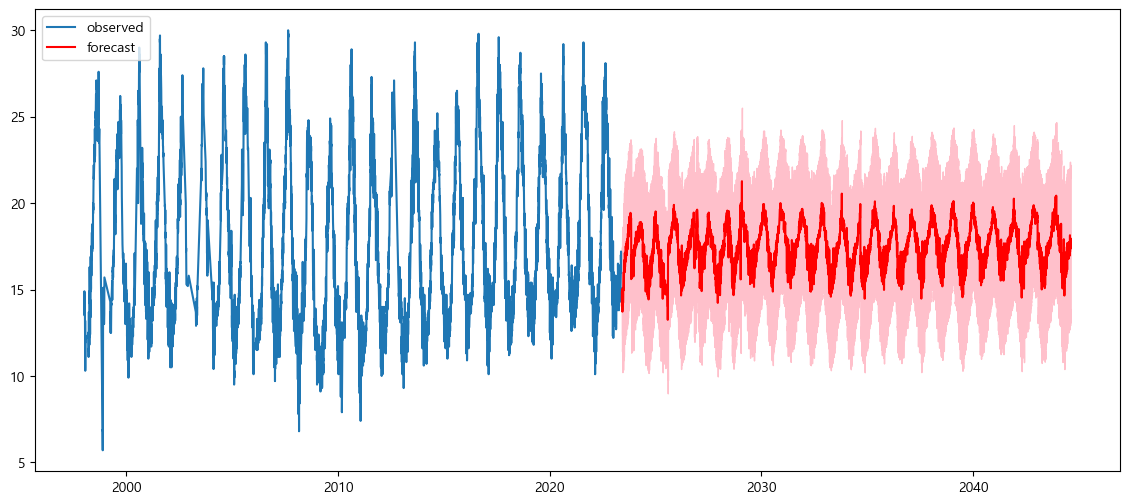

                                      SARIMAX Results                                       
Dep. Variable:                            평균 수온(°C)   No. Observations:                 7744
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 18)   Log Likelihood               -9497.879
Date:                              Wed, 31 May 2023   AIC                          19017.757
Time:                                      15:12:08   BIC                          19094.259
Sample:                                           0   HQIC                         19043.985
                                             - 7744                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
평균 풍속(m/s)     -0.0335      0.005     -7.308      0.000      -0.043      -0.025
평균기압(hPa)       

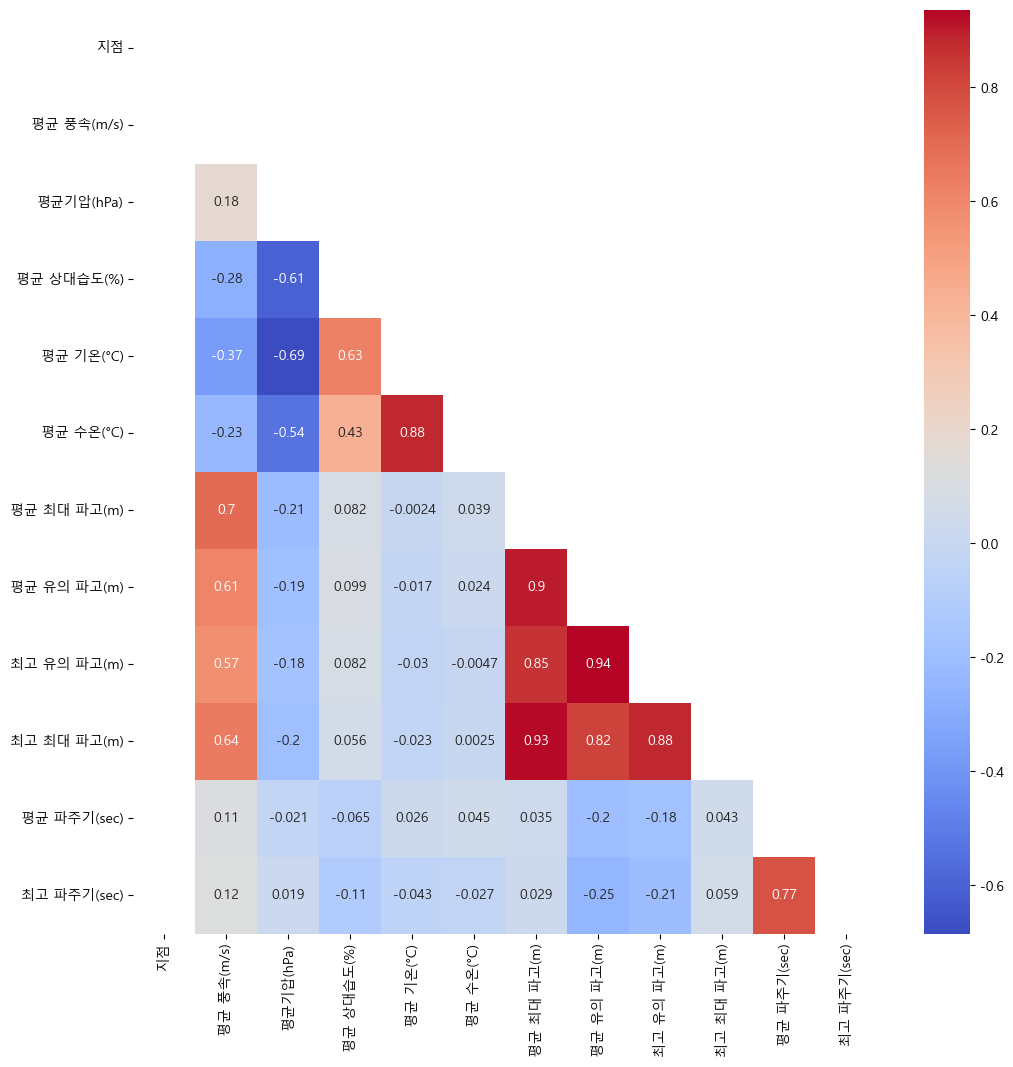

In [108]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230519거문도해양데이터.csv', parse_dates=True, encoding='utf-8')

data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환
data = data.drop(['index'],axis=1)

data = data.rename(columns={'일시': 'date'})  # 열 이름 변경
data['date'] = pd.to_datetime(data['date'], format="%Y.%m")  # 날짜 형식으로 변환
data = data.rename(columns={'date': '일시'})
data = data.set_index('일시')  # 다시 인덱스로 설정

print(data)
# 스케일링
# 인덱스를 PeriodIndex로 변환합니다.
# data = data.iloc[::-1]
# data.index = pd.date_range(start='2013-01-06', periods=len(data), freq='d')
# exog를 다시 정의합니다.
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
print(exog)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['평균 수온(°C)'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 18), exog=exog)

results = model.fit(disp=False)

# 예측 기간을 설정합니다.
forecast_steps = len(data)

# 예측 결과와 신뢰 구간을 얻습니다.
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
# forecast_index = pd.period_range(start=data.index[-1] + timedelta64(1, 'M'), periods=forecast_steps, freq='M')

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
forecast_index = pd.period_range(start='2023-05-31', periods=forecast_steps, freq='d')
print(forecast_index)

forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index.strftime('%Y-%m-%d')
forecast_conf_int.index = forecast_index.strftime('%Y-%m-%d')
print(forecast.predicted_mean)

# predicted_mean df 인덱스 추가(아래 mysql 저장 위해)
predicted_mean = pd.DataFrame(forecast.predicted_mean)
predicted_mean.index = forecast_index.strftime('%Y-%m-%d')
print('forecast.predicted_mean',forecast.predicted_mean)

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['평균 수온(°C)'], label='observed')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['평균 수온(°C)'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(y_pred)
y_pred.to_csv('forecast_results(stemp).csv', index=True, index_label='date')

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True, mask=mask)
plt.show()

forecast.predicted_mean.to_csv('data/stemp_data_day_forecast.csv', index=False)
data.to_csv('data/stemp_data_day_data.csv', index=False)

In [109]:
# data
# forecast.predicted_mean
# forecast_conf_int


import pymysql
from sqlalchemy import create_engine, types

# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'stemp'

# 인덱스 복구
data = data.reset_index()
forecast_conf_int = forecast_conf_int.reset_index()
predicted_mean = predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [data, predicted_mean, forecast_conf_int]  # 첫 번째 요소들의 리스트
list2 = ['stemprealgmday', 'stempforegmday', 'stempforeconfgmday']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.Date(), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()

0       1998-01-08
1       1998-01-09
2       1998-01-10
3       1998-01-11
4       1998-01-12
           ...    
8389    2023-05-14
8390    2023-05-15
8391    2023-05-16
8392    2023-05-17
8393    2023-05-18
Name: 일시, Length: 8394, dtype: object
            평균 풍속(m/s)    평균기압(hPa)  평균 상대습도(%)  평균 기온(°C)  평균 수온(°C)  \
일시                                                                      
1998-02-28         NaN          NaN         NaN        NaN        NaN   
1998-03-31    6.731250  1024.793333    5.466667   6.246667  11.980000   
1998-04-30    5.625926  1016.111111   82.925926  13.466667  13.718519   
1998-05-31    4.940000  1013.493548   91.580645  17.535484  17.461290   
1998-06-30    6.922727  1007.917391   89.956522  19.321739  19.873913   
...                ...          ...         ...        ...        ...   
2022-12-31    8.058065  1023.938710   61.967742   6.954839  15.680645   
2023-01-31    7.758065  1023.900000   64.645161   7.038710  14.541935   
2023-02-28    6.539286 

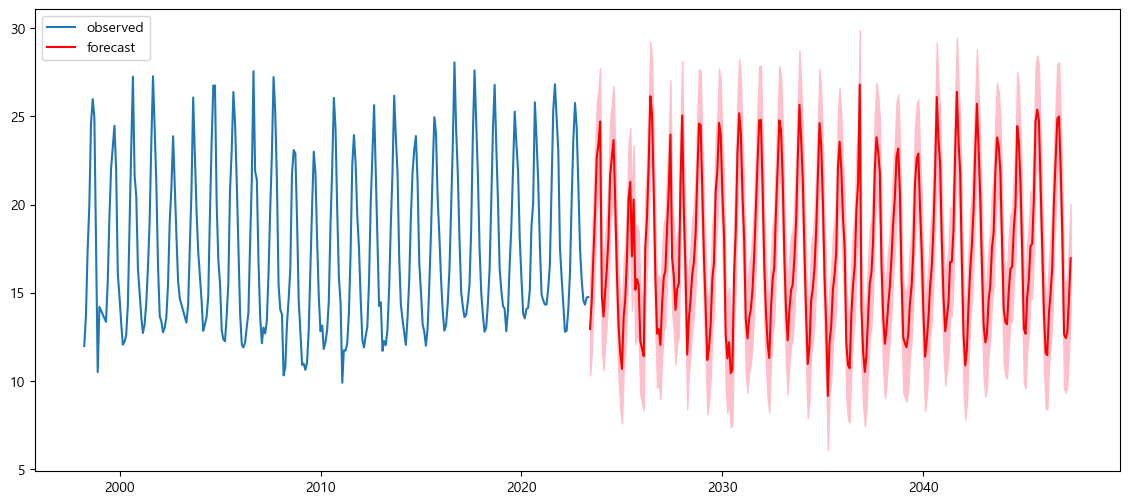

                                      SARIMAX Results                                       
Dep. Variable:                            평균 수온(°C)   No. Observations:                  288
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 18)   Log Likelihood                -492.240
Date:                              Wed, 31 May 2023   AIC                           1006.481
Time:                                      15:10:28   BIC                           1046.773
Sample:                                           0   HQIC                          1022.628
                                              - 288                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
평균 풍속(m/s)      0.5118      0.087      5.853      0.000       0.340       0.683
평균기압(hPa)       

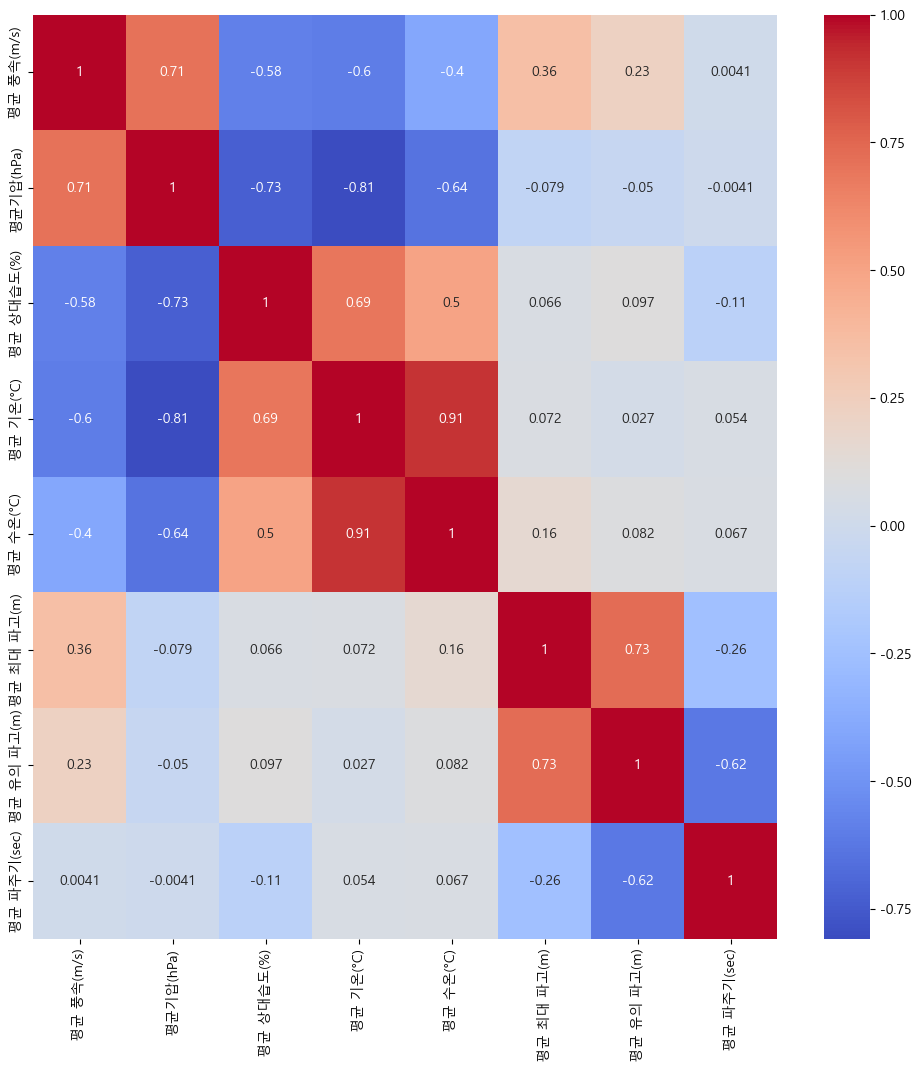

                                      SARIMAX Results                                       
Dep. Variable:                            평균 수온(°C)   No. Observations:                  288
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 18)   Log Likelihood                -492.240
Date:                              Wed, 31 May 2023   AIC                           1006.481
Time:                                      15:10:28   BIC                           1046.773
Sample:                                           0   HQIC                          1022.628
                                              - 288                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
평균 풍속(m/s)      0.5118      0.087      5.853      0.000       0.340       0.683
평균기압(hPa)       

288    12.945555
289    14.490763
290    17.060673
291    19.636548
292    22.696036
         ...    
571    12.647889
572    12.427190
573    12.738582
574    14.686460
575    16.956764
Name: predicted_mean, Length: 288, dtype: float64

In [106]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230519거문도해양데이터.csv', parse_dates=True, encoding='utf-8')
date = data['일시']
date=date.dropna()
print(date)
data=data.set_index(pd.to_datetime(data.일시)) # Date를 인덱스로
data.index = pd.to_datetime(data.index)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('M').mean()
data = data.iloc[1:-1]

print(data)
data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환
# data = data.drop(['index'],axis=1)

data = data.rename(columns={'일시': 'date'})  # 열 이름 변경
# data['date'] = pd.to_datetime(data['date'], format="%Y.%m")  # 날짜 형식으로 변환
data = data.rename(columns={'date': '일시'})
data = data.set_index('일시')  # 다시 인덱스로 설정

print(data)
# 스케일링
# 스케일링
# 인덱스를 PeriodIndex로 변환합니다.
# data = data.iloc[::-1]
# data.index = pd.date_range(start='2013-01-06', periods=len(data), freq='d')
# exog를 다시 정의합니다.
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
print(exog)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['평균 수온(°C)'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 18), exog=exog)

results = model.fit(disp=False)

# 예측 기간을 설정합니다.
forecast_steps = len(data)

# 예측 결과와 신뢰 구간을 얻습니다.
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
# forecast_index = pd.period_range(start=data.index[-1] + timedelta64(1, 'M'), periods=forecast_steps, freq='M')
# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
forecast_index = pd.period_range(start='2023-05-19', periods=forecast_steps, freq='M')
print('forecast_index',forecast_index)

forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index.strftime('%Y-%m-%d')

# predicted_mean df 인덱스 추가(아래 mysql 저장 위해)
predicted_mean = pd.DataFrame(forecast.predicted_mean)
predicted_mean.index = forecast_index.strftime('%Y-%m-%d')
print('forecast.predicted_mean',forecast.predicted_mean)

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['평균 수온(°C)'], label='observed')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['평균 수온(°C)'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('y_pred',y_pred)
y_pred.to_csv('forecast_results(stemp).csv', index=True, index_label='date')

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

print(results.summary())

forecast.predicted_mean.to_csv('data/stemp_data_month_forecast.csv', index=False)
data.to_csv('data/stemp_data_month_data.csv', index=False)

forecast.predicted_mean

In [107]:
# data
# forecast.predicted_mean
# forecast_conf_int


import pymysql
from sqlalchemy import create_engine, types

# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'stemp'

# 인덱스 복구
data = data.reset_index()
forecast_conf_int = forecast_conf_int.reset_index()
predicted_mean = predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [data, predicted_mean, forecast_conf_int]  # 첫 번째 요소들의 리스트
list2 = ['stemprealgmmonth', 'stempforegmmonth', 'stempforeconfgmmonth']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.Date(), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()

0       1998-01-08
1       1998-01-09
2       1998-01-10
3       1998-01-11
4       1998-01-12
           ...    
8389    2023-05-14
8390    2023-05-15
8391    2023-05-16
8392    2023-05-17
8393    2023-05-18
Name: 일시, Length: 8394, dtype: object
            평균 풍속(m/s)    평균기압(hPa)  평균 상대습도(%)  평균 기온(°C)  평균 수온(°C)  \
일시                                                                      
1999-12-31    6.129832  1012.368750   78.791667  17.957083  19.185833   
2000-12-31    6.435507  1016.946233   66.195205  13.591096  16.574910   
2001-12-31    6.417009  1017.965782   54.107143  14.405310  17.908260   
2002-12-31    6.279600  1015.468750   75.661417  15.267717  16.518750   
2003-12-31    5.609302  1012.503846   81.484615  19.893077  19.543411   
2004-12-31    6.164194  1017.672333   72.050000  16.327835  18.061538   
2005-12-31    6.742071  1019.066667   73.893939  15.720909  17.664242   
2006-12-31    5.365101  1015.089937   76.827044  16.932704  17.591054   
2007-12-31    6.179558 

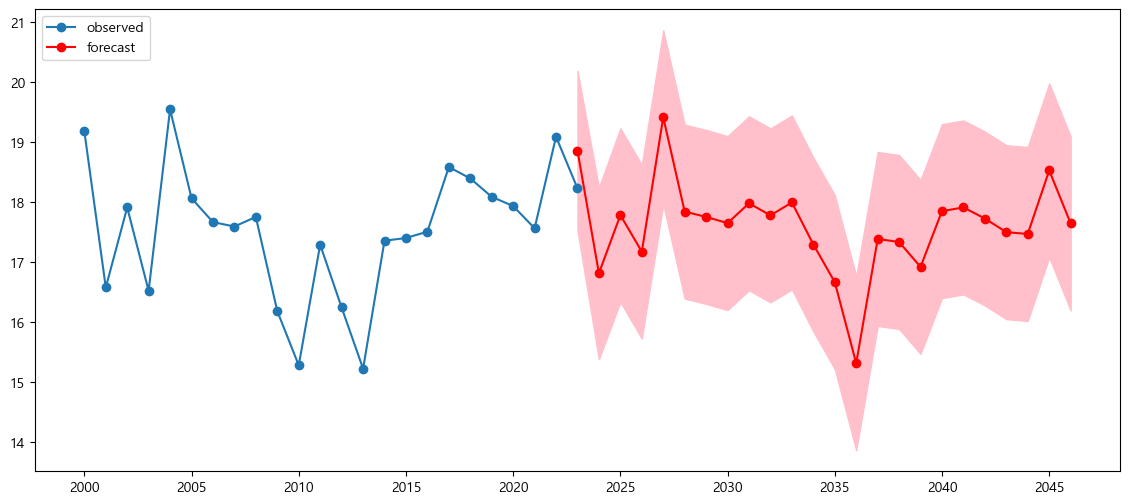

                                      SARIMAX Results                                       
Dep. Variable:                            평균 수온(°C)   No. Observations:                   24
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 18)   Log Likelihood                 -23.981
Date:                              Wed, 31 May 2023   AIC                             69.962
Time:                                      14:26:45   BIC                             82.921
Sample:                                  12-31-1999   HQIC                            73.400
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
평균 풍속(m/s)      0.2844      2.551      0.111      0.911      -4.716       5.285
평균기압(hPa)       

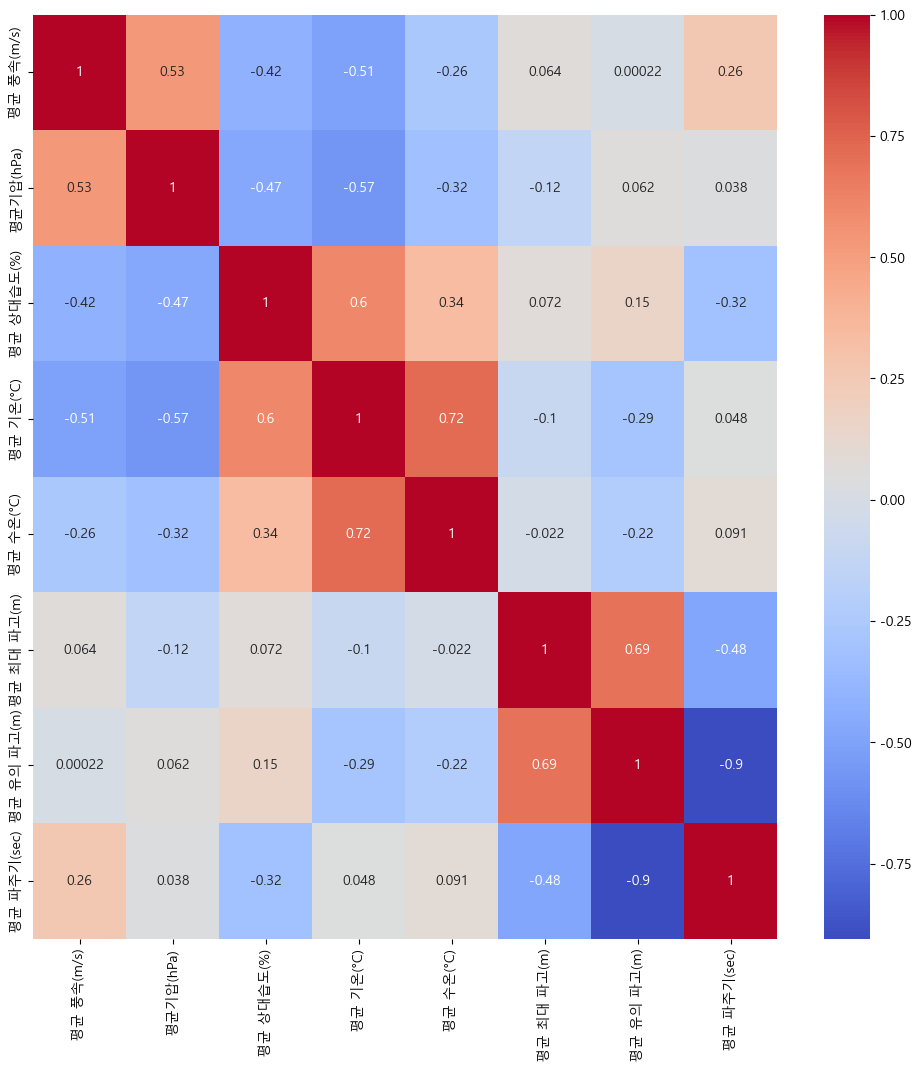

                                      SARIMAX Results                                       
Dep. Variable:                            평균 수온(°C)   No. Observations:                   24
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 18)   Log Likelihood                 -23.981
Date:                              Wed, 31 May 2023   AIC                             69.962
Time:                                      14:26:45   BIC                             82.921
Sample:                                  12-31-1999   HQIC                            73.400
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
평균 풍속(m/s)      0.2844      2.551      0.111      0.911      -4.716       5.285
평균기압(hPa)       

In [77]:
# csv 파일을 읽어옵니다.
from sklearn.preprocessing import StandardScaler,robust_scale
import pandas as pd
# 데이터를 불러옵니다.
data = pd.read_csv('data/20230519거문도해양데이터.csv', parse_dates=True, encoding='utf-8')
date = data['일시']
date=date.dropna()
print(date)
data=data.set_index(pd.to_datetime(data.일시)) # Date를 인덱스로
data.index = pd.to_datetime(data.index)
data = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 수온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']].resample('Y').mean()
data = data.iloc[1:-1]

print(data)
data = data.sort_values('일시', ascending=True)
data.loc[data['평균 수온(°C)'] == 0, '평균 수온(°C)'] = np.nan
data=data.dropna()

data = data.reset_index()  # 인덱스를 열로 변환
# data = data.drop(['index'],axis=1)

data = data.rename(columns={'일시': 'date'})  # 열 이름 변경
# data['date'] = pd.to_datetime(data['date'], format="%Y.%m")  # 날짜 형식으로 변환
data = data.rename(columns={'date': '일시'})
data = data.set_index('일시')  # 다시 인덱스로 설정

print(data)
# 스케일링
# 스케일링
# 인덱스를 PeriodIndex로 변환합니다.
# data = data.iloc[::-1]
# data.index = pd.date_range(start='2013-01-06', periods=len(data), freq='d')
# exog를 다시 정의합니다.
exog = data[['평균 풍속(m/s)','평균기압(hPa)','평균 상대습도(%)','평균 기온(°C)','평균 최대 파고(m)','평균 유의 파고(m)','평균 파주기(sec)']]
print(exog)
# 시계열 모델을 학습합니다.
model = SARIMAX(data['평균 수온(°C)'], order=(1, 0, 0), seasonal_order=(1, 0, 1, 18), exog=exog)

results = model.fit(disp=False)

# 예측 기간을 설정합니다.
forecast_steps = len(data)

# 예측 결과와 신뢰 구간을 얻습니다.
forecast = results.get_forecast(steps=forecast_steps, exog=exog[-forecast_steps:])
forecast_conf_int = forecast.conf_int()
# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
from numpy import timedelta64

# 예측 결과의 인덱스를 원본 데이터와 동일한 시간 범위로 설정합니다.
# forecast_index = pd.period_range(start=data.index[-1] + timedelta64(1, 'M'), periods=forecast_steps, freq='M')

# forecast_index = pd.period_range(data.index[-1] + 1, periods=forecast_steps, freq='M')
forecast_index = pd.period_range(start='2022-05-19', periods=forecast_steps, freq='y')
print('forecast_index',forecast_index)

forecast_index_timestamp = forecast_index.to_timestamp()  # PeriodIndex를 Timestamp로 변환
forecast.predicted_mean.index = forecast_index
forecast_conf_int.index = forecast_index.strftime('%Y-%m-%d')
print('forecast.predicted_mean',forecast.predicted_mean)

# 결과를 시각화합니다.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['평균 수온(°C)'], label='observed', marker='o', linestyle='-')
plt.plot(forecast_index, forecast.predicted_mean, label='forecast', color='r', marker='o', linestyle='-')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend(loc='upper left')
plt.show()

print(results.summary())

# 예측 오차 계산
from sklearn.metrics import mean_squared_error
import numpy as np

y_true = data['평균 수온(°C)'][-forecast_steps:]
y_pred = forecast.predicted_mean
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(y_pred)
y_pred.to_csv('forecast_results(stemp).csv', index=True, index_label='date')

# 예측 오차 출력
print('RMSE:', rmse)
import seaborn as sns

corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

print(results.summary())

forecast.predicted_mean.to_csv('data/stemp_data_month_forecast.csv', index=False)
data.to_csv('data/stemp_data_month_data.csv', index=False)

In [ ]:
# data
# forecast.predicted_mean
# forecast_conf_int


import pymysql
from sqlalchemy import create_engine, types

# Establish a connection to MySQL
host = 'localhost'
user = 'root'
password = '1234'
database = 'stemp'

# 인덱스 복구
data = data.reset_index()
forecast_conf_int = forecast_conf_int.reset_index()
forecast.predicted_mean = forecast.predicted_mean.reset_index()

conn = pymysql.connect(host=host, user=user, password=password, database=database)

# Create a SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

list1 = [data, forecast.predicted_mean, forecast_conf_int]  # 첫 번째 요소들의 리스트
list2 = ['stemprealgmyear', 'stempforegmyear', 'stempforeconfgmyear']  # 두 번째 요소들의 리스트

for item1, item2 in zip(list1, list2):
    # 각 요소들을 item1, item2 변수에 할당하여 반복문 실행
    table_name = item2
    dtype = {'일시': types.Date(), '평균 풍속(m/s)': types.Float(), '평균기압(hPa)': types.Float(), '평균 상대습도(%)': types.Float(), '평균 기온(°C)': types.Float(), 
             '평균 수온(°C)': types.Float(), '평균 최대 파고(m)': types.Float(), '평균 유의 파고(m)': types.Float(), '평균 파주기(sec)': types.Float()}
    item1.to_sql(table_name, engine, if_exists='replace', index=False, dtype=dtype)

conn.close()